In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install seaborn[stats]==0.12.2 seaborn[statsmodels]
!pip install u8darts[all]
!pip install git+https://github.com/amazon-science/chronos-forecasting.git
!pip install torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import numpy as np
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [19]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Data/AutoGluon/PJM_Load_hourly.csv")
df['datetime'] = pd.to_datetime(df['Datetime'])
df['freq'] = 'H'
df['target'] = df['PJM_Load_MW']
df.head()


,Datetime,PJM_Load_MW,datetime,freq,target
0,4/1/1998 1:00,22259,1998-04-01 01:00:00,H,22259
1,4/1/1998 2:00,21244,1998-04-01 02:00:00,H,21244
2,4/1/1998 3:00,20651,1998-04-01 03:00:00,H,20651
3,4/1/1998 4:00,20421,1998-04-01 04:00:00,H,20421
4,4/1/1998 5:00,20713,1998-04-01 05:00:00,H,20713


In [20]:
hours_in_one_week = 7 * 24
test_df = df.iloc[-hours_in_one_week:]
df = df.iloc[:-hours_in_one_week]
(df.shape, test_df.shape)

((32679, 5), (168, 5))

In [34]:
context = torch.tensor(df["target"])
prediction_length = 168 #1 week

forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=200,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
    limit_prediction_length=False
) # forecast shape: [num_series, num_samples, prediction_length]


/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:440: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


In [35]:
# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

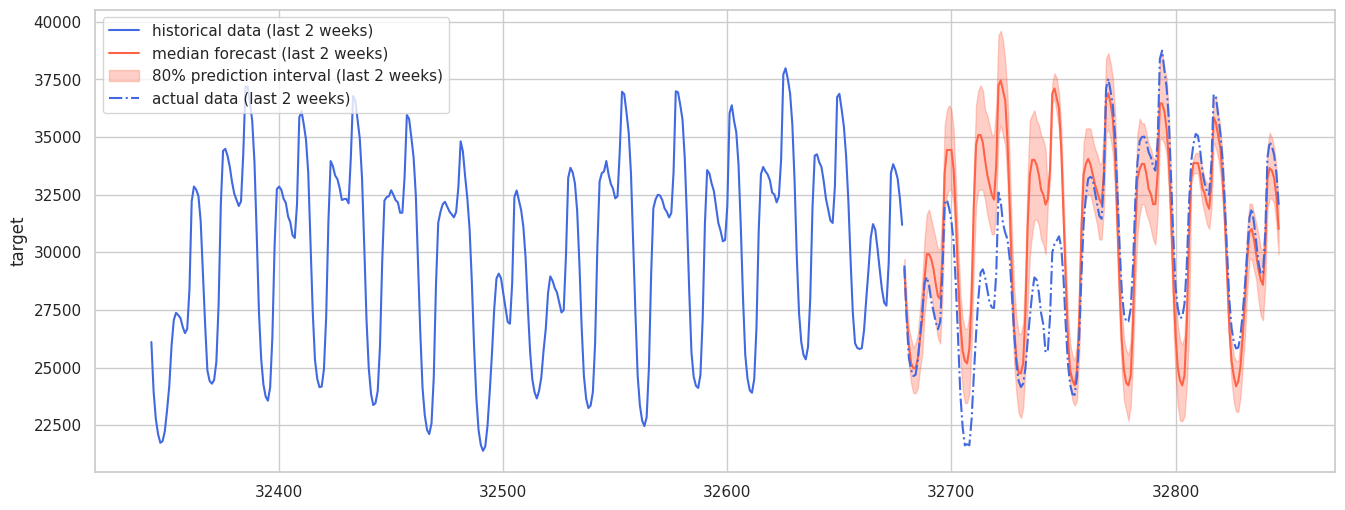

In [36]:
# This is the zoomed in plot showing 2 weeks
hours_in_two_weeks = 2 * 7 * 24
df_last_two_weeks = df[-hours_in_two_weeks:]
forecast_index_last_two_weeks = forecast_index[-hours_in_two_weeks:]
median_last_two_weeks = median[-hours_in_two_weeks:]
low_last_two_weeks = low[-hours_in_two_weeks:]
high_last_two_weeks = high[-hours_in_two_weeks:]

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_last_two_weeks, x=df_last_two_weeks.index, y="target", color="royalblue", label="historical data (last 2 weeks)")
sns.lineplot(x=forecast_index_last_two_weeks, y=median_last_two_weeks, color="tomato", label="median forecast (last 2 weeks)")
plt.fill_between(forecast_index_last_two_weeks, low_last_two_weeks, high_last_two_weeks, color="tomato", alpha=0.3, label="80% prediction interval (last 2 weeks)")
# We'll only plot the portion of test_df that corresponds to the last two weeks
test_df_last_two_weeks = test_df[-hours_in_two_weeks:]
sns.lineplot(data=test_df_last_two_weeks, x=test_df_last_two_weeks.index, y="target", color="royalblue", linestyle='-.', label="actual data (last 2 weeks)")
plt.legend()
plt.show()